<div class="alert alert-info">
Ссылка для просмотра ноутбука в интерактивном режиме для использования гиперссылок и корректного отображения разметки:<br>
<a href='https://nbviewer.org/github/yulianikola/portfolio/blob/master/data_analysis_python/3_hypothesis/AB_test_cookie.ipynb'>AB_test_cookie</a></div>

### АВ-тест
#### Игра Cookie Cats

<div class="alert alert-info">
Cookie Cats - популярная мобильная игра-головоломка, разработанная Tactile Entertainment. Это классическая игра-головоломка в стиле «соедините три», в которой игрок должен соединять плитки одного цвета, чтобы очистить поле и выиграть уровень. 
</div>

<p style="align: center;"><img align=center src="https://i.ytimg.com/vi/iPxZIp0cbJE/maxresdefault.jpg"  width=500></p>
 
 
<p style="align: center;"><img align=center src="https://s3.amazonaws.com/assets.datacamp.com/production/project_184/img/cc_gates.png"  width=500></p>


<div class="alert alert-info">
По мере прохождения уровней игры игроки время от времени сталкиваются с воротами, которые заставляют их ждать нетривиальное количество времени или совершать покупки в приложении, чтобы продолжить. Помимо стимулирования покупок в приложении, эти ворота служат важной цели - дать игрокам вынужденный перерыв в игре, что, как мы надеемся, приведет к увеличению и продлению удовольствия от игры.
</div>

<div class="alert alert-info">
<b>Но где ставить ворота? </b>
Первоначально первые ворота были размещены на уровне 30. В этом проекте вам предлагается проанализировать AB-тест, в котором создатели переместили первые ворота в Cookie Cats с 30 уровня на уровень 40. В частности, вам надо рассмотреть влияние A/B теста на удержание игроков.
</div>

**Данные получены от 90 189 игроков, которые установили игру во время проведения AB-теста. Переменные:**

* `userid` - уникальный номер, идентифицирующий каждого игрока.

* `version` - был ли игрок помещен в контрольную группу (gate_30 - ворота на уровне 30) или в тестовую группу (gate_40 - ворота на уровне 40).

* `sum_gamerounds` - количество игровых раундов, сыгранных игроком в течение первой недели после установки
* `retention_1` - проигрыватель вернулся и поиграл через 1 день после установки?
* `retention_7` - проигрыватель вернулся и играл через 7 дней после установки?

Когда игрок устанавливал игру, ему случайным образом назначали `gate_30` или `gate_40`.

<h4>Содержание</h4><br>
<p id="0">
<ul type="square"><a href="#1"><li>Знакомство с данными</li></a>
<a href="#2"><li>Влияние на возвращаемость игрока (Хи-кв Пирсона)</li></a>
    <ul><a href="#2.1"><li>через 1 день</li></a>
    <a href="#2.2"><li>через 7 дней</li></a></ul>
<a href="#3"><li>Влияние на кол-во раундов</li></a> 
    <ul><a href="#3.1"><li>Т-тест</li></a>
    <a href="#3.2"><li>Манн-Уитни</li></a>
    <a href="#3.3"><li>Логарифмирование</li></a></ul>
<a href="#4"><li>Выводы</li></a>

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats 
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
data = pd.read_csv('c:\\python\\portfolio\\data_analysis_python\\2_hypothesis\\data\\cookie_cats.csv')
data.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


<p id="1">
<h4>EDA</h4><br>

В датасете 90189 строк, пропусков нет. По столбцам userid и sum_gamerounds определился числовой тип данных, значит среди их значений нет нечисловых символов, которыми могут обозначать пропущенные значения:

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB


Судя по значениям столбцов категориальных признаков, "нестандартных" пустот вроде "?" нет:

In [5]:
print(data.version.unique())
print('')
print(data.retention_1.unique())
print('')
print(data.retention_7.unique())

['gate_30' 'gate_40']

[False  True]

[False  True]


Дубликатов в столбце userid нет, так как число уникальных значений равно числу строк. Значит нет пользователей, попавших и в контрольную и в тестовую группы:

In [6]:
data.userid.nunique()

90189

В тестовой группе немного больше игроков:

In [7]:
data.version.value_counts(normalize = True)

gate_40    0.504374
gate_30    0.495626
Name: version, dtype: float64

Среди участников теста через день вернулись к игре 45%, через 7 дней  - 19%. При этом 51% не вернулись к игре ни через 1 ни через 7 дней (но это не значит, что они не вернулись в промежутке, просто это не фиксировалось):

In [8]:
pd.crosstab(data.retention_1, data.retention_7, normalize = True, margins = True )

retention_7,False,True,All
retention_1,,,
False,0.514885,0.039905,0.55479
True,0.299050,0.146160,0.44521
All,0.813935,0.186065,1.00000


Посмотрим статистики единственного числового показателя количества сыгранных раундов. 

In [9]:
data.sum_gamerounds.describe()

count    90189.000000
mean        51.872457
std        195.050858
min          0.000000
25%          5.000000
50%         16.000000
75%         51.000000
max      49854.000000
Name: sum_gamerounds, dtype: float64

Минимальное значение сыгранных раундов 0, таких игроков 3994. Мы не можем знать, вернулись ли они вообще к игре за время эксперимента. Так как у нас зафиксировано возвращение только через день и через семь, а игроки могли вернуться в промежутке. Среди людей сыгравших 0 раундов могут быть те, кто не вернулся вообще и те, кто вернулся, но не прошел ни одного раунда. Этого мы выяснить не можем, поэтому с игроками с нулевыми раундами ничего не предпринимаем.

In [10]:
len(data[data.sum_gamerounds == 0])

3994

При том, что 75% участников сыграли не более чем по 51 раундов, максимальное значение 49854 раунда. Может быть ошибка или выбросы. Значение в 49854 раунда одно такое и очень значительно отличается от остальных значений:

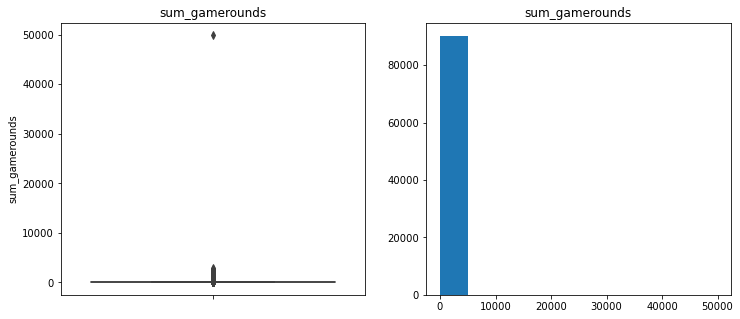

In [11]:
plt.figure(figsize = (12, 5)) 
plt.subplot(1,2,1)
sns.boxplot(y = data.sum_gamerounds);
plt.title('sum_gamerounds');
plt.subplot(1,2,2)
plt.hist(data.sum_gamerounds);
plt.title('sum_gamerounds');

Посмотрим на этого игрока. Он относится к контрольной группе, где ворота на 30 уровне. Он не вернулся в игру через день, но вернулся через 7 дней:

In [12]:
data[data.sum_gamerounds == data.sum_gamerounds.max()]

,userid,version,sum_gamerounds,retention_1,retention_7
57702,6390605,gate_30,49854,False,True


Чтобы решить, что это ошибка, нужно знать, какое кол-во раундов вообще возможно в этой игре. Но даже если такое кол-во возможно, то это без сомнения выброс, искажающий данные. Поэтому исключим его:

In [13]:
data_1 = data[data.sum_gamerounds < data.sum_gamerounds.max()]

Теперь посмотрим на статистики, гистограмму и боксплот без выброса. Распределение все равно очень асимметричное, сильно скошено вправо, очень длинный правый хвост.

In [14]:
data_1.sum_gamerounds.describe()

count    90188.000000
mean        51.320253
std        102.682719
min          0.000000
25%          5.000000
50%         16.000000
75%         51.000000
max       2961.000000
Name: sum_gamerounds, dtype: float64

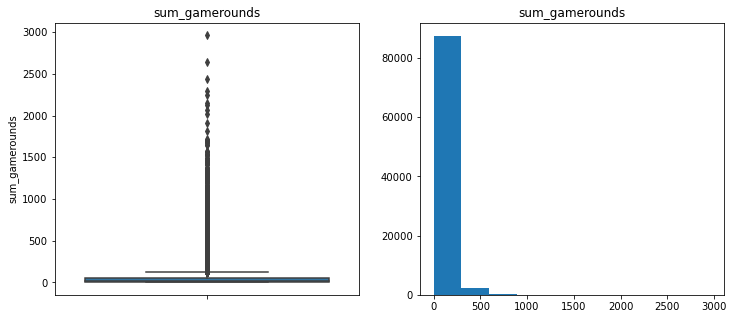

In [15]:
plt.figure(figsize = (12, 5)) 
plt.subplot(1,2,1)
sns.boxplot(y = data_1.sum_gamerounds);
plt.title('sum_gamerounds');
plt.subplot(1,2,2)
plt.hist(data_1.sum_gamerounds);
plt.title('sum_gamerounds');

Посчитаем нижнюю границу выбросов правого хвоста по расчетам боксплота и границу так называемых экстремальных выбросов. Даже граница для экстремальных выбросов всего 189, а значения доходят почти до 3000:

In [16]:
up_out = (data_1.sum_gamerounds.describe()['75%'] + 1.5 * (data_1.sum_gamerounds.describe()['75%']
                                                           - data_1.sum_gamerounds.describe()['25%'] ))
up_out_ext = (data_1.sum_gamerounds.describe()['75%'] + 3 * (data_1.sum_gamerounds.describe()['75%']
                                                             - data_1.sum_gamerounds.describe()['25%'] )
up_out, up_out_ext 

(120.0, 189.0)

Будем считать, что раунды (сыгранные за неделю раунды, в показателе sum_gamerounds) и уровни (по которым устанавливаются ворота, 30й или 40й) это одно и то же понятие. Цель АВ-теста оценить влияние ворот на 30 или 40 уровне. На мой взгляд, если за неделю игрок прошел очень много уровней (в количестве достаточно отдаленном от 30 или 40), то вряд ли его поведение (по кол-ву раундов или возвращаемости) связано с воротами, которые были относительно в "самом начале". То есть если у ворот на 30/40 уровне есть эффект, то маловероятно, что он будет длиться до 200го, 500го, 1000го и тд уровней. Поэтому сделаем еще одну версию датасета, исключив игроков с выбросами по sum_gamerounds по экстремальной границе. Ниже проверим результаты тестов на устойчивость к таким изменениям:

In [17]:
data_2 = data_1[data_1.sum_gamerounds < up_out_ext ]

Число записей сократилось с 90189 до 84449:

In [18]:
data_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 84449 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          84449 non-null  int64 
 1   version         84449 non-null  object
 2   sum_gamerounds  84449 non-null  int64 
 3   retention_1     84449 non-null  bool  
 4   retention_7     84449 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.7+ MB


Статистики sum_gamerounds после исключения выбросов:

In [19]:
data_2.sum_gamerounds.describe()

count    84449.000000
mean        30.625703
std         39.138814
min          0.000000
25%          4.000000
50%         14.000000
75%         41.000000
max        188.000000
Name: sum_gamerounds, dtype: float64

После исключения выбросов на гистограмме стало видно правый хвост:

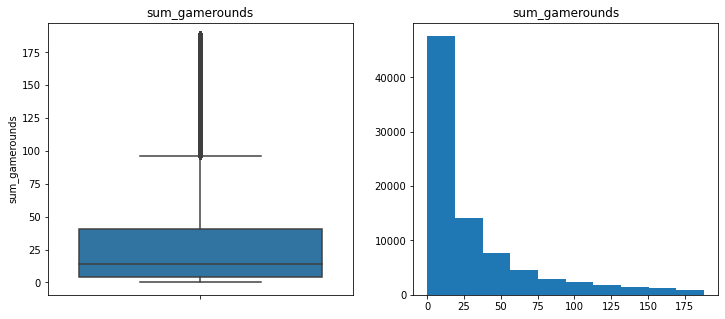

In [20]:
plt.figure(figsize = (12, 5)) 
plt.subplot(1,2,1)
sns.boxplot(y = data_2.sum_gamerounds);
plt.title('sum_gamerounds');
plt.subplot(1,2,2)
plt.hist(data_2.sum_gamerounds);
plt.title('sum_gamerounds');

Распределение возвращаемости игроков (на 1й и/или 7й дни) изменились незначительно после исключения выбросов:

In [21]:
pd.crosstab(data_2.retention_1, data_2.retention_7, normalize = True, margins = True )

retention_7,False,True,All
retention_1,,,
False,0.548911,0.039018,0.587929
True,0.309358,0.102713,0.412071
All,0.858269,0.141731,1.000000


Соотношение контрольной и тестовой группы почти не изменилось:

In [22]:
data_2.version.value_counts(normalize = True)

gate_40    0.504612
gate_30    0.495388
Name: version, dtype: float64

<a href="#0"><h4>Наверх</h4></a>

<p id="2">
<h4> Влияние положения ворот на возвращаемость игрока</h4><br>

Разделим данные (без одного яркого выброса) на контрольную и тестовую группы:

In [23]:
gate_30 = data_1[data_1.version == 'gate_30']
gate_40 = data_1[data_1.version == 'gate_40']

Распределение возвращаемости игроков (на 1й и/или 7й дни) очень похожи между контрольной и тестовой группами:

In [24]:
pd.crosstab(gate_30.retention_1, gate_30.retention_7, normalize = True, margins = True )

retention_7,False,True,All
retention_1,,,
False,0.510973,0.040829,0.551802
True,0.298843,0.149355,0.448198
All,0.809817,0.190183,1.000000


In [25]:
pd.crosstab(gate_40.retention_1, gate_40.retention_7, normalize = True, margins = True )

retention_7,False,True,All
retention_1,,,
False,0.518741,0.038976,0.557717
True,0.299259,0.143024,0.442283
All,0.818000,0.182000,1.000000


Разделим данные (без экстремальных выбросов) на контрольную и тестовую группы:

In [26]:
gate_30_2 = data_2[data_2.version == 'gate_30']
gate_40_2 = data_2[data_2.version == 'gate_40']

<a href="#0"><h4>Наверх</h4></a>

<p id="2.1">
<h5>Влияние на возвращаемость через 1 день (retention_1)</h5><br>

Доля вернувшихся почти одинаковы 44%:

In [27]:
print(gate_30[['version','retention_1']].value_counts(normalize = True))
print(gate_40[['version','retention_1']].value_counts(normalize = True))

version  retention_1
gate_30  False          0.551802
         True           0.448198
dtype: float64
version  retention_1
gate_40  False          0.557717
         True           0.442283
dtype: float64


Категориальный признак, группы две, независимые - тест Хи-квадрат Пирсона.

* Нулевая гипотеза: независимость retention_1 и положения ворот, отсутствие взаимосвязи между ними, разница в возвращаемости через день между контрольной и тестовой группами случайна
* Альтернативная: между возвращаемостью через 1 день и положением ворот есть взаимосвязь, разница в возвращаемости через день между контрольной и тестовой группами не случайна

Подготовим таблицу сопряженности для теста:

In [28]:
cont_matrix_ret1 = pd.crosstab(data_1.version, data_1.retention_1)
cont_matrix_ret1

retention_1,False,True
version,,
gate_30,24665,20034
gate_40,25370,20119


Тест непараметрический и не требует нормальности распределения. Таблица сопряженности это матрица 2 на 2, но в каждой из ячеек достаточно записей, поэтому нет необходимости в поправке Йетса:

In [29]:
stats.chi2_contingency(cont_matrix_ret1, correction = False)

(3.19373895460949,
 0.07392076034183397,
 1,
 array([[24798.35970417, 19900.64029583],
        [25236.64029583, 20252.35970417]]))

* При условии, что Н0 верна (разница между группами случайна), вероятность полученного (или более экстремального) значения тестовой статистики около 7%.
* Здесь и далее возьмем общепринятый 5% уровень значимости.
* При уровне значимости 5%  недостаточно аргументов для отвержения нулевой гипотезы.
* Не отвергаем Н0 в пользу Н1.
* Разница в возвращаемости через 1 день для контрольной и тестовой групп случайна. То есть нет взаимосвязи между положением ворот и возвращаемостью через 1 день. Количества вернувшихся и невернувшихся в группе с воротами на 30м уровне не отличаются статистически значимо от количеств в группе с воротами на 40м уровне.

В статистике это считается р-хаккингом, но для проверки устойчивости результата можно провести тест на данных без экстремальных выбросов:

In [30]:
cont_matrix_ret1_2 = pd.crosstab(data_2.version, data_2.retention_1)
cont_matrix_ret1_2

retention_1,False,True
version,,
gate_30,24481,17354
gate_40,25169,17445


P-значение больше - 11%, при выбранном уровне значимости по-прежнему не отвергаем Н0:

In [31]:
stats.chi2_contingency(cont_matrix_ret1_2, correction = False)

(2.5859146143058958,
 0.10781811314914272,
 1,
 array([[24596.00172885, 17238.99827115],
        [25053.99827115, 17560.00172885]]))

Возвращаемость игрока всего через один день имеет не такое важное значение для бизнеса как более долгосрочное удержание игрока. Больший интерес представляет показатель возвращаемости через семь дней.

<a href="#0"><h4>Наверх</h4></a>

<p id="2.2">
<h5>Влияние на возвращаемость через 7 дней (retention_7)</h5><br>

Доля вернувшихся почти одинаковы 19%:

In [32]:
print(gate_30[['version','retention_7']].value_counts(normalize = True))
print(gate_40[['version','retention_7']].value_counts(normalize = True))

version  retention_7
gate_30  False          0.809817
         True           0.190183
dtype: float64
version  retention_7
gate_40  False          0.818
         True           0.182
dtype: float64


* Нулевая гипотеза: независимость retention_7 и положения ворот, отсутствие взаимосвязи между ними, разница в возвращаемости через 7 дней между контрольной и тестовой группами случайна
* Альтернативная: между возвращаемостью через 7 дней и положением ворот есть взаимосвязь, разница в возвращаемости через 7 дней между контрольной и тестовой группами не случайна

Подготовим таблицу сопряженности для теста:

In [33]:
cont_matrix_ret7_1 = pd.crosstab(data_1.version, data_1.retention_7)
cont_matrix_ret7_1

retention_7,False,True
version,,
gate_30,36198,8501
gate_40,37210,8279


In [34]:
stats.chi2_contingency(cont_matrix_ret7_1, correction = False)

(9.96923845042939,
 0.0015917731773992998,
 1,
 array([[36382.49203885,  8316.50796115],
        [37025.50796115,  8463.49203885]]))

* При условии, что Н0 верна (разница между группами случайна), вероятность полученного (или более экстремального) значения тестовой статистики по сути равна 0, данные показывают очень маловероятные результаты.
* Даже при уровне значимости 1% аргументов в пользу H0 по сути нет.
* Отвергаем Н0 в пользу Н1.
* Разница в возвращаемости через 7 дней для контрольной и тестовой групп НЕ случайна. То есть положение ворот и возвращаемость через 7 дней взаимосвязаны. Количества вернувшихся и невернувшихся в группе с воротами на 30м уровне статистически значимо отличаются от количеств в группе с воротами на 40м уровне.

В статистике это считается р-хаккингом, но для проверки устойчивости результата можно провести тест на данных без экстремальных выбросов:

In [35]:
cont_matrix_ret7_2 = pd.crosstab(data_2.version, data_2.retention_7)
cont_matrix_ret7_2

retention_7,False,True
version,,
gate_30,35735,6100
gate_40,36745,5869


Р-значение стало еще ближе к нулю и мы по-прежнему отвергаем Н0:

In [36]:
stats.chi2_contingency(cont_matrix_ret7_2, correction = False)

(11.347572804375679,
 0.0007554663854888557,
 1,
 array([[35905.70403439,  5929.29596561],
        [36574.29596561,  6039.70403439]]))

Тест показал взаимосвязь между положением ворот и возвращаемостью игроков через 7дней. Но, к сожалению, мы не знаем в каком направлении: лучше ворота на 30м или 40м уровне. Протестировать направление изменения нам позволит числовой показатель.

<a href="#0"><h4>Наверх</h4></a>

<p id="3">
<h4>Влияние на количество пройденных раундов (sum_gamerounds)</h4><br>
<p id="3.1">
<h5>Т-тест</h5><br>

Ворота изначально стоят на уровне 30 и нас интересует, нужно ли что-то менять. Нет смысла что-то менять, если ворота на уровне 40 по результату хуже или не отличаются от ситуации с уровнем 30. Есть смысл что-то поменять, если ворота на уровне 40 по результату лучше. Поэтому с помощью теста хочется ответить на вопрос, в случае с воротами на уровне 40 будет лучше или нет (хуже или нет разницы). Сформулируем гипотезы:<br>
* Нулевая гипотеза: среднее кол-во раундов в тестовой группе равно или меньше чем в контрольной.
* Альтернативная: среднее кол-во раундов в тестовой группе gate_40 больше чем в контрольной gate_30.

Посмотрим на гистограммы пройденных раундов для контрольной и тестовой групп. Без исключения экстремальных выбросов на гистограммах практически не виден хвост, но по видимой части гистограмм кажется, что они довольно схожи:

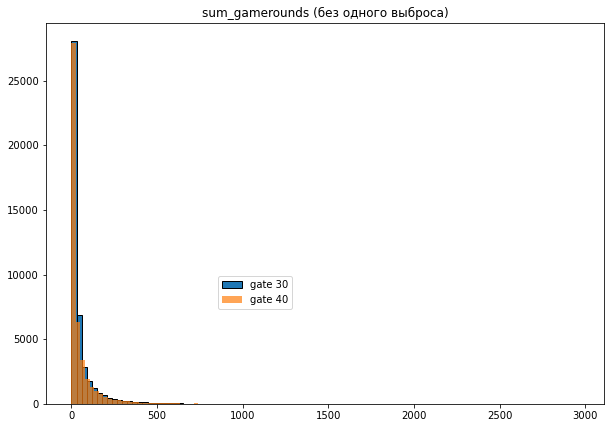

In [37]:
bins = 100
plt.figure(figsize = (10, 7))
plt.hist(gate_30.sum_gamerounds, bins = bins, alpha = 1, edgecolor = 'black', label = 'gate 30')
plt.hist(gate_40.sum_gamerounds, bins = bins, alpha = 0.7, label = 'gate 40')
plt.legend(loc = 'upper right', bbox_to_anchor = (0.45, 0.35))
plt.title('sum_gamerounds (без одного выброса)')
plt.show()

Посмотрим данные без экстремальных выбросов. Гистограммы тоже выглядят очень похоже. Но где-то в районе 30-40 уровней виднеется возвышение частот контрольной группы на тестовой. Возможно это как раз связано с тем, что если эффект от положение ворот на 30-40 уровне и есть, то длится недолго. Поэтому в дополнение возможно стоит рассмотреть совсем усеченные данные, например, с кол-вом раундов от 30 до 60.

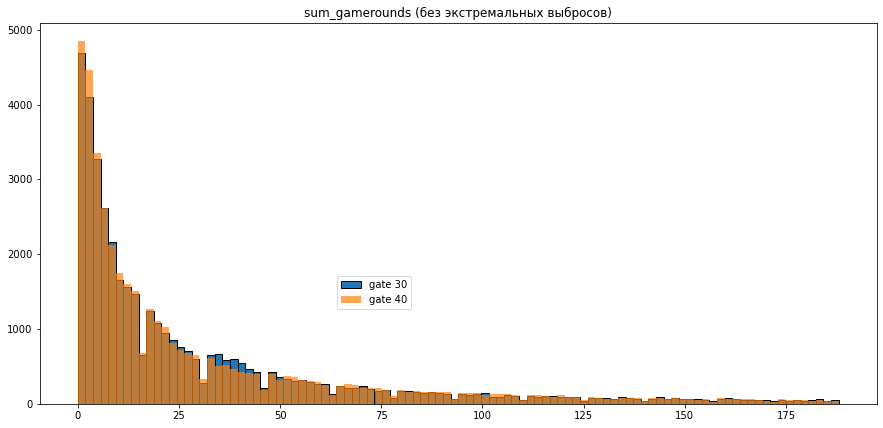

In [38]:
bins = 100
plt.figure(figsize = (15, 7))
plt.hist(gate_30_2.sum_gamerounds, bins = bins, alpha = 1, edgecolor = 'black', label = 'gate 30')
plt.hist(gate_40_2.sum_gamerounds, bins = bins, alpha = 0.7, label = 'gate 40')
plt.legend(loc = 'upper right', bbox_to_anchor = (0.45, 0.35))
plt.title('sum_gamerounds (без экстремальных выбросов)')
plt.show()

В выборках среднее число раундов в группах почти одинаково:

In [39]:
print('среднее число раундов в контрольной группе', gate_30.sum_gamerounds.mean())
print('среднее число раундов в тестовой группе', gate_40.sum_gamerounds.mean())

среднее число раундов в контрольной группе 51.342110561757536
среднее число раундов в тестовой группе 51.29877552814966


Распределения в группах асимметричные и не похожие на нормальные, но в каждой из групп около 45 тыс записей, поэтому положимся на ЦПТ и будем считать распределения средних количеств раундов нормальными:

In [40]:
print(gate_30.shape)
print(gate_40.shape)

(44699, 5)
(45489, 5)


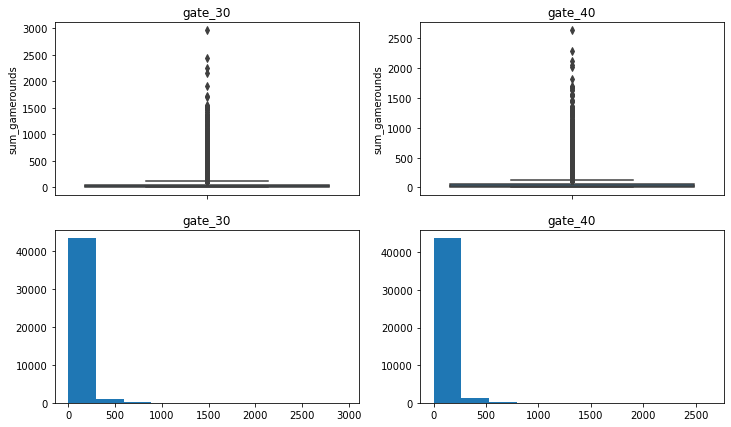

In [41]:
plt.figure(figsize = (12, 7)) 
plt.subplot(2,2,1)
sns.boxplot(y = gate_30.sum_gamerounds);
plt.title('gate_30');
plt.subplot(2,2,2)
sns.boxplot(y = gate_40.sum_gamerounds);
plt.title('gate_40');
plt.subplot(2,2,3)
plt.hist(gate_30.sum_gamerounds);
plt.title('gate_30');
plt.subplot(2,2,4)
plt.hist(gate_40.sum_gamerounds);
plt.title('gate_40');

Признак количественный. Две независимых выборки, сравниваем два средних. Используем Т-тест для независимых выборок, односторонний, так как нам важно направление.

Равны ли дисперсии контрольной и тестовой групп? Разницы между выборочными стандартными отклонениями практически нет. Есть мнение, что при разнице больше 5% считать дисперсии неравными. Есть отдельная группа тестов для проверки равенства дисперсий. Есть мнение, что поправка Уэлча для профилактики не должна навредить. Есть мнение, что использование поправки в случае, когда дисперсии равны, увеличивает вероятность ошибки 2го рода (не отвергнуть некорректную нулевую). В документации теста ttest_ind сказано, что в случае неравных дисперсий, отсутствие поправки занижает р значение. Опираясь на практически отсутствие разницы между ср.кв.откл, поправку Уэлча делать не будем и попробуем учесть все остальные "но" при интерпретации.

In [42]:
print('ско раундов gate_30 ', gate_30.sum_gamerounds.std())
print('ско раундов gate_40 ', gate_40.sum_gamerounds.std())
print('относительная разница ско ', (gate_40.sum_gamerounds.std() - gate_30.sum_gamerounds.std()) /
      gate_30.sum_gamerounds.std())

ско раундов gate_30  102.05759789214098
ско раундов gate_40  103.29441621653784
относительная разница ско  0.01211882652484129


Т-тест:

In [43]:
t,p = stats.ttest_ind(gate_40.sum_gamerounds, gate_30.sum_gamerounds, alternative = 'greater', equal_var = False)
print(t,p)

-0.06337426312892294 0.5252656892267771


* При условии, что Н0 верна (т.е. среднее число раундов в тестовой равно или меньше чем в контрольной), данные не противоречат Н0. 
* При условии, что Н0 верна, вероятность полученного (или более экстремального) значения тестовой статистики около 53%.
* По нашим данным достаточно аргументов в пользу H0.
* Не отвергаем Н0 в пользу Н1.
* Среднее кол-во раундов в тестовой равно или меньше чем в контрольной. То есть нет смысла переставлять ворота с 30го на 40й уровень с целью увеличить число сыгранных раундов.

Так как поправку на случай неравенства дисперсий не сделали, то есть риск, что р-значение занижено, если дисперсии на самом деле не равны. Но р-значение настолько большое, что в данном случае его заниженность особого значения не имеет. Можем для проверки провести тест с поправкой, хотя в статистике так не принято и это считается р-хаккингом. Наличие поправки на тест практически не повлияло:

In [44]:
t,p = stats.ttest_ind(gate_40.sum_gamerounds, gate_30.sum_gamerounds, alternative = 'greater', equal_var = True)
print(t,p)

-0.0633675766982082 0.5252630270872


Для проверки устойчивости результата проведем тест на данных без экстремальных выбросов. P-значение стало меньше - 43%, но по-прежнему достаточно аргументов в пользу Н0:

In [45]:
print('среднее число раундов в контрольной группе без выбросов', gate_30_2.sum_gamerounds.mean())
print('среднее число раундов в тестовой группе без выбросов', gate_40_2.sum_gamerounds.mean())

среднее число раундов в контрольной группе без выбросов 30.60203179156209
среднее число раундов в тестовой группе без выбросов 30.648941662364482


In [46]:
t,p = stats.ttest_ind(gate_40_2.sum_gamerounds, gate_30_2.sum_gamerounds, alternative = 'greater', equal_var = False)
print(t,p)

0.17415619552656236 0.4308715638935539


<a href="#0"><h4>Наверх</h4></a>

<p id="3.2">
<h5>Критерий Манна Уитни</h5><br>

Также можно проверить устойчивость теста к предположению нормальности распределения и провести непараметрический тест Манна-Уитни. Если предположить, что у равных распределений равные медианы, то: 
* Нулевая гипотеза: медианное кол-во раундов в тестовой группе равно или меньше чем в контрольной.
* Альтернативная: медианное кол-во раундов в тестовой группе больше чем в контрольной.

Выборочная медиана в контрольной группе чуть больше чем в тестовой, 17 против 16:

In [47]:
data_1.groupby('version').median('sum_gamerounds')['sum_gamerounds']

version
gate_30    17.0
gate_40    16.0
Name: sum_gamerounds, dtype: float64

Тест Манна-Уитни:

In [48]:
stat, p = stats.mannwhitneyu(gate_40.sum_gamerounds, gate_30.sum_gamerounds, alternative = 'greater')
stat, p

(1009027049.5, 0.97455423878383)

* При условии, что Н0 верна (т.е. медианное число раундов в тестовой равно или меньше чем в контрольной), данные не противоречат Н0. 
* При условии, что Н0 верна, вероятность полученного (или более экстремального) значения тестовой статистики около 97%.
* По нашим данным более чем достаточно аргументов в пользу H0.
* Не отвергаем Н0 в пользу Н1.
* Медианное кол-во раундов в тестовой группе равно или меньше чем в контрольной. То есть нет смысла переставлять ворота с 30го на 40й уровень с целью увеличить число сыгранных раундов.

<a href="#0"><h4>Наверх</h4></a>

<p id="3.3">
<h5>Т-тест и логарифмирование</h5><br>

Логарифм такого скошенного вправо распределения может иметь более похожее на нормальное распределение. Как мы уже выяснили выше у нас есть 3994 записи с нулевым кол-вом раундов:

In [49]:
len(data[data['sum_gamerounds'] == 0])

3994

Для логарифмирования нам придется исключить этих игроков:

In [50]:
data_log = data.loc[:]
data_log = data_log[data_log['sum_gamerounds'] > 0]

Добавляем столбец с натуральным логарифмом sum_gamerounds:

In [51]:
data_log['log_sum_rounds'] = np.log(data_log['sum_gamerounds'])
data_log.head()

,userid,version,sum_gamerounds,retention_1,retention_7,log_sum_rounds
0,116,gate_30,3,False,False,1.098612
1,337,gate_30,38,True,False,3.637586
2,377,gate_40,165,True,False,5.105945
3,483,gate_40,1,False,False,0.000000
4,488,gate_40,179,True,True,5.187386


Теперь гистограмма выглядит более похожей на нормальную:

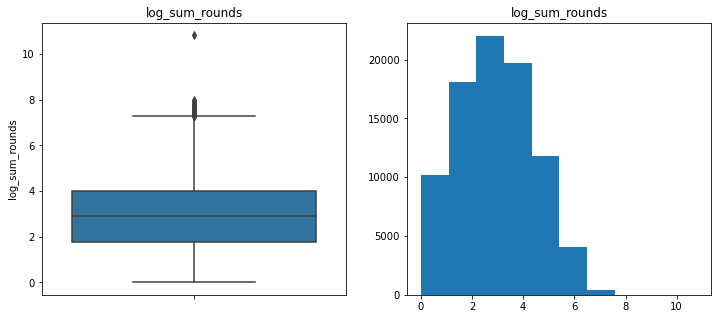

In [52]:
plt.figure(figsize = (12, 5)) 
plt.subplot(1,2,1)
sns.boxplot(y = data_log.log_sum_rounds);
plt.title('log_sum_rounds');
plt.subplot(1,2,2)
plt.hist(data_log.log_sum_rounds);
plt.title('log_sum_rounds');

Уберем выброс sum_gamerounds = 49854:

In [53]:
data_log_1 = data_log[data_log.sum_gamerounds < data_log.sum_gamerounds.max()]

Гистограмма и боксплот без самого яркого выброса sum_gamerounds:

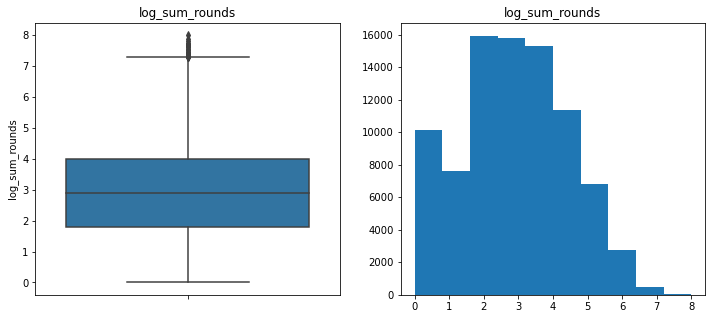

In [54]:
plt.figure(figsize = (12, 5)) 
plt.subplot(1,2,1)
sns.boxplot(y = data_log_1.log_sum_rounds);
plt.title('log_sum_rounds');
plt.subplot(1,2,2)
plt.hist(data_log_1.log_sum_rounds);
plt.title('log_sum_rounds');

Если убрать экстремальные выбросы по sum_gamerounds после 189:

In [55]:
data_log_2 = data_log[data_log.sum_gamerounds < 189]

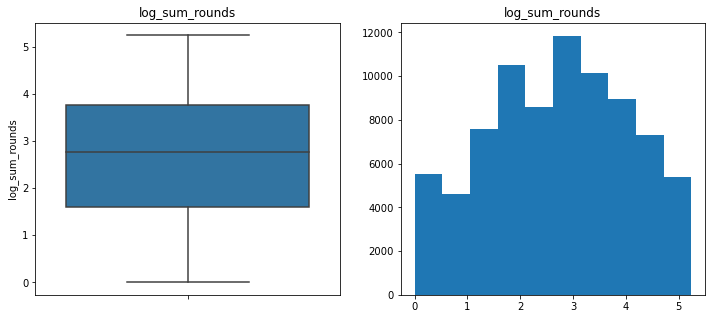

In [56]:
plt.figure(figsize = (12, 5)) 
plt.subplot(1,2,1)
sns.boxplot(y = data_log_2.log_sum_rounds);
plt.title('log_sum_rounds');
plt.subplot(1,2,2)
plt.hist(data_log_2.log_sum_rounds);
plt.title('log_sum_rounds');

Разделим данные (без нулевых раундов и без яркого выброса) на контрольную и тестовую группы:

In [57]:
gate_30_log = data_log_1[data_log_1.version == 'gate_30']
gate_40_log = data_log_1[data_log_1.version == 'gate_40']

Разделим данные (без нулевых раундов и без экстремальных выбросов) на контрольную и тестовую группы:

In [58]:
gate_30_log_2 = data_log_2[data_log_2.version == 'gate_30']
gate_40_log_2 = data_log_2[data_log_2.version == 'gate_40']

Сформулируем гипотезы:<br>
* Нулевая гипотеза: средний логарифм кол-ва раундов в тестовой группе равен или меньше чем в контрольной.
* Альтернативная: средний логарифм кол-ва раундов в тестовой группе gate_40 больше чем в контрольной gate_30.

Средние в группах почти одинаковые, в контрольной чуть больше:

In [59]:
print('средний логарифм числа раундов в контрольной группе', gate_30_log.log_sum_rounds.mean())
print('средний логарифм числа раундов в тестовой группе', gate_40_log.log_sum_rounds.mean())

средний логарифм числа раундов в контрольной группе 2.8895630046553813
средний логарифм числа раундов в тестовой группе 2.87454313039857


Равны ли дисперсии контрольной и тестовой групп? Разницы между выборочными стандартными отклонениями практически нет, поправку Уэлча делать не будем и попробуем учесть все остальные "но" при интерпретации.

In [60]:
print('ско раундов gate_30 ', gate_30_log.log_sum_rounds.std())
print('ско раундов gate_40 ', gate_40_log.log_sum_rounds.std())
print('относительная разница ско ', (gate_40_log.log_sum_rounds.std() - gate_30_log.log_sum_rounds.std()) /
      gate_30_log.log_sum_rounds.std())

ско раундов gate_30  1.5413621223499008
ско раундов gate_40  1.5518205519748396
относительная разница ско  0.006785186604296659


Т-тест:

In [61]:
t,p = stats.ttest_ind(gate_40_log.log_sum_rounds, gate_30_log.log_sum_rounds, alternative = 'greater', equal_var = False)
print(t,p)

-1.4255913668463311 0.9230050243427721


* При условии, что Н0 верна (т.е. средний логарифм числа раундов в тестовой равен или меньше чем в контрольной), данные не противоречат Н0. 
* При условии, что Н0 верна, вероятность полученного (или более экстремального) значения тестовой статистики около 92%.
* По нашим данным более чем достаточно аргументов в пользу H0.
* Не отвергаем Н0 в пользу Н1.
* Средний логарифм кол-ва раундов в тестовой равен или меньше чем в контрольной.

Т-тест на данных без экстремальных выбросов дает почти такой же результат:

In [62]:
t,p = stats.ttest_ind(gate_40_log_2.log_sum_rounds, gate_30_log_2.log_sum_rounds, alternative = 'greater', equal_var = False)
print(t,p)

-1.4002338223846083 0.9192764163885482


<a href="#0"><h4>Наверх</h4></a>

<p id="4">
<h4>Выводы</h4><br>

* Тест Хи-квадрат Пирсона не показал статистически значимых различий между вернувшимися/невернувшимися через день игроками и положением ворот. Практическая значимость различий тоже отсутствует: 0.448 доля вернувшихся gate_30 и 0.442 в gate_40.
* Тест Хи-квадрат Пирсона показал статистически значимые различия между вернувшимися/невернувшимися через семь дней игроками и положением ворот. С практической точки зрения различия в доле вернувшихся не значимы: 0.19 в gate_30 и 0.182 в gate_40.
* Т-тест не отверг гипотезу о том, что среднее кол-во раундов в тестовой группе равно или меньше, чем в контрольной. Практически значимого различия тоже нет: 51.34 в gate_30 и 51.29 в gate_40.
* Проверили устойчивость выводов Т-теста: провели Т-тест на данных без экстремальных выбросов; провели непараметрический тест на равенство медиан; провели Т-тест на логарифме кол-ва раундов. Противоречий не возникло.
* Нет смысла переставлять ворота с 30 уровня для увеличения возвращаемости и сыгранных раундов.